# Compare REM and HAND approaches

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import py3dep
import rasterio
import rioxarray
from pynhd import NHD, prepare_nhdplus
import whitebox
from shapely import box
import xrspatial
import pysheds
import shapely

import os
import tempfile

In [2]:
xmin = -119.1
xmax = -119.0
ymin = 34.40
ymax = 34.50

aoi = box(xmin, ymin, xmax, ymax)
aoi_with_buffer = box(xmin-.02, ymin-.02, xmax+.02, ymax+.02)
# this helps with NoData values at boundaries during operations

In [3]:
nhd = NHD('flowline_mr')

dem = py3dep.get_map("DEM", aoi_with_buffer, resolution=10, geo_crs=4326, crs=4326)
flow = nhd.bygeom(aoi, geo_crs=4326)

In [4]:
dem = dem.rio.reproject(3310)
flow = flow.to_crs(3310)

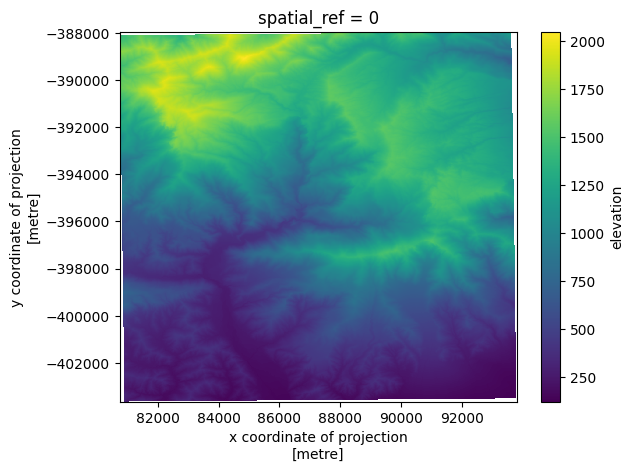

In [5]:
dem.where(dem > 0).plot()

In [7]:
# get coordinates of start and end of each flowline
# keep only the one with the lowest elevation
def get_pour_point(flowline, dem):
    start_point = shapely.Point(flowline.coords[0])
    end_point = shapely.Point(flowline.coords[-1])
    elev_start_point = get_elev(start_point, dem)
    elev_end_point = get_elev(end_point, dem)

    if elev_start_point > elev_end_point:
        return shapely.Point(end_point)
    else:
        return shapely.Point(start_point)

def get_elev(point, dem):
    z = dem.sel(x=point.x, y=point.y, method='nearest').item()
    return z

In [9]:
# clip each line to the bounds and get pour points
flow['geometry'] = flow['geometry'].apply(lambda x: x.intersection(aoi))
flow

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,geometry,OBJECTID,FDATE,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FCODE,Shape_Length,RESOLUTION,FLOWDIR,FTYPE,PERMANENT_IDENTIFIER,WBAREA_PERMANENT_IDENTIFIER,GLOBALID
0,LINESTRING Z EMPTY,128975,942969600000,None,None,2.898,18070102001932,46003,3524.342778,3,1,460,17572729,None,{2C7674E1-2C81-418E-9CEA-EFE35626B6E6}
1,LINESTRING Z EMPTY,128977,942969600000,00269983,Boulder Creek,1.268,18070102002124,46003,1540.803729,3,1,460,17572777,None,{B96F648C-44AF-4293-9957-C6BACBF9EE6B}
2,LINESTRING Z EMPTY,128978,942969600000,00249095,Santa Paula Creek,0.927,18070102000400,46006,1126.231386,3,1,460,17572797,None,{73934BEE-2E53-4DEE-B6BA-A7A1E54E7021}
3,LINESTRING Z EMPTY,128980,942969600000,None,None,1.758,18070102001904,46003,2128.466175,3,1,460,17572831,None,{4E81D0E3-473E-449A-886A-041524D26AA2}
4,LINESTRING Z EMPTY,128981,942969600000,None,None,1.945,18070102001903,46003,2356.659204,3,1,460,17572833,None,{837A9EC5-4AF3-4718-808D-72DFC26A9BDB}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,LINESTRING Z EMPTY,2773409,942969600000,None,None,1.906,18070102001894,46003,2318.303451,3,1,460,17574281,None,{523D36E5-0DBC-45E8-BA04-57A1EA125F15}
81,LINESTRING Z EMPTY,2872198,987552000000,None,None,0.175,18070102001922,46003,211.006303,3,1,460,17572677,None,{29A4DBF8-4794-4428-BF70-B56BFC1F5ADF}
82,LINESTRING Z EMPTY,2960567,942969600000,00249095,Santa Paula Creek,2.179,18070102000408,46006,2641.156989,3,1,460,17572719,None,{5D306E2D-14CF-4276-85D6-16CEB3A73CA3}
83,LINESTRING Z EMPTY,2960568,942969600000,None,None,3.214,18070102001931,46003,3903.736384,3,1,460,17572727,None,{296793D6-4462-481B-93F2-0CED52635722}


In [ ]:
pour_points = gpd.GeoSeries([get_pour_point(line, dem=dem) for line in flow['geometry']], index=flow.index)
pour_points.head(4)

In [64]:
for geom in flow['geometry']:
    start_point = shapely.Point(geom.coords[0])
    end_point = shapely.Point(geom.coords[-1])
    zs = get_elev(start_point, dem)
    ze = get_elev(end_point, dem)
    print (zs, ze)

1602.4793701171875 955.3646850585938
1361.6103515625 1225.2659912109375
343.1012268066406 311.58404541015625
993.7444458007812 469.9660339355469
982.0911865234375 469.9660339355469
1491.80615234375 1455.1728515625
1330.533203125 1321.2572021484375
1326.314208984375 1313.53466796875
1227.575439453125 1177.734619140625
631.9800415039062 551.9156494140625
1282.166259765625 345.8440856933594
807.0416259765625 311.58404541015625
239.3031005859375 186.85171508789062
639.7462768554688 312.8406982421875
1581.6295166015625 1550.4959716796875
1517.8643798828125 1256.1231689453125
955.3646850585938 877.0978393554688
1245.6270751953125 173.21978759765625
665.2022705078125 485.1463623046875
1396.588134765625 1246.92578125
1719.91162109375 1030.6422119140625
1828.1966552734375 1550.4959716796875
1424.7518310546875 705.5560913085938
624.505859375 239.3031005859375
463.5338439941406 199.06124877929688
312.8406982421875 300.2357177734375
1301.743896484375 1289.1331787109375
1455.1728515625 1438.8553466

In [70]:
flow

,geometry,OBJECTID,FDATE,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FCODE,Shape_Length,RESOLUTION,FLOWDIR,FTYPE,PERMANENT_IDENTIFIER,WBAREA_PERMANENT_IDENTIFIER,GLOBALID
0,LINESTRING Z EMPTY,128975,942969600000,None,None,2.898,18070102001932,46003,3524.342778,3,1,460,17572729,None,{2C7674E1-2C81-418E-9CEA-EFE35626B6E6}
1,LINESTRING Z EMPTY,128977,942969600000,00269983,Boulder Creek,1.268,18070102002124,46003,1540.803729,3,1,460,17572777,None,{B96F648C-44AF-4293-9957-C6BACBF9EE6B}
2,LINESTRING Z EMPTY,128978,942969600000,00249095,Santa Paula Creek,0.927,18070102000400,46006,1126.231386,3,1,460,17572797,None,{73934BEE-2E53-4DEE-B6BA-A7A1E54E7021}
3,LINESTRING Z EMPTY,128980,942969600000,None,None,1.758,18070102001904,46003,2128.466175,3,1,460,17572831,None,{4E81D0E3-473E-449A-886A-041524D26AA2}
4,LINESTRING Z EMPTY,128981,942969600000,None,None,1.945,18070102001903,46003,2356.659204,3,1,460,17572833,None,{837A9EC5-4AF3-4718-808D-72DFC26A9BDB}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,LINESTRING Z EMPTY,2773409,942969600000,None,None,1.906,18070102001894,46003,2318.303451,3,1,460,17574281,None,{523D36E5-0DBC-45E8-BA04-57A1EA125F15}
81,LINESTRING Z EMPTY,2872198,987552000000,None,None,0.175,18070102001922,46003,211.006303,3,1,460,17572677,None,{29A4DBF8-4794-4428-BF70-B56BFC1F5ADF}
82,LINESTRING Z EMPTY,2960567,942969600000,00249095,Santa Paula Creek,2.179,18070102000408,46006,2641.156989,3,1,460,17572719,None,{5D306E2D-14CF-4276-85D6-16CEB3A73CA3}
83,LINESTRING Z EMPTY,2960568,942969600000,None,None,3.214,18070102001931,46003,3903.736384,3,1,460,17572727,None,{296793D6-4462-481B-93F2-0CED52635722}


<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

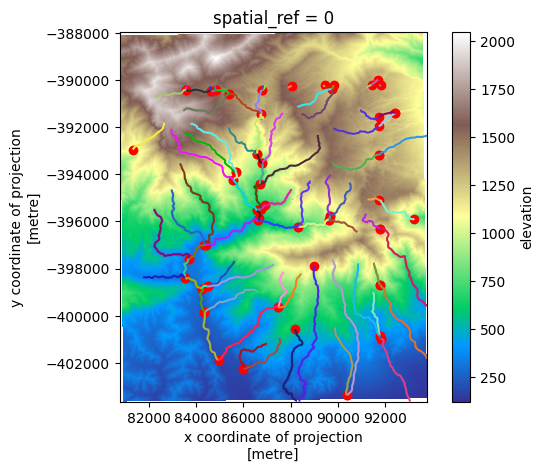

In [65]:
fig, ax = plt.subplots()
colors = [tuple(c) for c in np.random.rand(len(flow['geometry']), 3)]

dem.where(dem > 0).plot(ax=ax, cmap='terrain')
flow['geometry'].plot(ax=ax, color=colors)
pour_points.plot(ax=ax, color='red')

use whiteboxtools:
- filldepressions
- d8pointer
- rasterizeStreams
- subbasins
- hillslopes
- ElevationAboveStream

In [9]:
def wb_wrapper(wbt_method, params, return_file=False):
    
    # for each param that is raster, save to file
    for p,v in params.items():
        if hasattr(v, 'rio'):
            # write v to temp file
            # update v to be the path to that file
            temp_file = tempfile.NamedTemporaryFile(suffix=".tif")
            v.rio.to_raster(temp_file.name, driver="GTiff")
            params[p] = temp_file.name
                

    # make function call
    wbt_method(**params)

    if return_file:
        return params['output']

    raster_file_path = params['output']
    output_raster = rioxarray.open_rasterio(raster_file_path)
    os.remove(raster_file_path)
    return output_raster 

def my_callback(value):
    if not "%" in value:
        print(value)

In [12]:
wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir("/Users/arthurkoehl/opt/WBT/")

working_directory = "/Users/arthurkoehl/programs/pasternack/valleys/"
wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

In [13]:
params = {
    "dem": dem,
    "output": os.path.join(working_directory, "filled_dem.tif"),
    "dist": 1000,
    "max_cost": None,
    "min_dist": True,
    "flat_increment": None,
    "fill": True,
    "callback": my_callback
}

filled_dem_file = wb_wrapper(wbt.breach_depressions_least_cost, params, return_file=True)
filled_dem_file

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --dem='/var/folders/n2/c76_7mv17f3fsmk9zkzn_k480000gn/T/tmpb5d1c_sl.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Num. solved pits: 193579
Num. unsolved pits: 0
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.527s


'/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif'

In [15]:
# d8 pointer
params = {
    "dem": filled_dem_file, 
    "output": os.path.join(working_directory, "d8_pntr.tif"), 
    "esri_pntr": False, 
    "callback": my_callback
}
d8_pntr_file = wb_wrapper(wbt.d8_pointer, params, return_file=True)

# note that to plot this need to take into account the nodata value, e.g:
# test = rioxarray.open_rasterio(d8_pntr_file)
# test.where(test != -32578).plot()

./whitebox_tools --run="D8Pointer" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --dem='/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.15s


In [16]:
# rasterize streams
flow.to_file(os.path.join(working_directory, 'flow.shp'))

params = {
    'streams': os.path.join(working_directory, 'flow.shp'),
    'base': d8_pntr_file,
    'output': os.path.join(working_directory, "streams.tif"), 
    'nodata': True, 
    'feature_id': True, 
    'callback': my_callback
}

stream_raster_file = wb_wrapper(wbt.rasterize_streams, params, return_file=True)

./whitebox_tools --run="RasterizeStreams" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --streams='/Users/arthurkoehl/programs/pasternack/valleys/flow.shp' --base='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --nodata --feature_id -v --compress_rasters=False

*******************************
* Welcome to RasterizeStreams *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Reading streams data...
Reading base raster data...
Counting stream cell adjacencies...
Number of stream cells: 5624
Number of stream collisions: 0
Number of stream adjacencies: 6
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.7s


/var/folders/n2/c76_7mv17f3fsmk9zkzn_k480000gn/T/ipykernel_40862/3565732380.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flow.to_file(os.path.join(working_directory, 'flow.shp'))


./whitebox_tools --run="Subbasins" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/basins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.53s


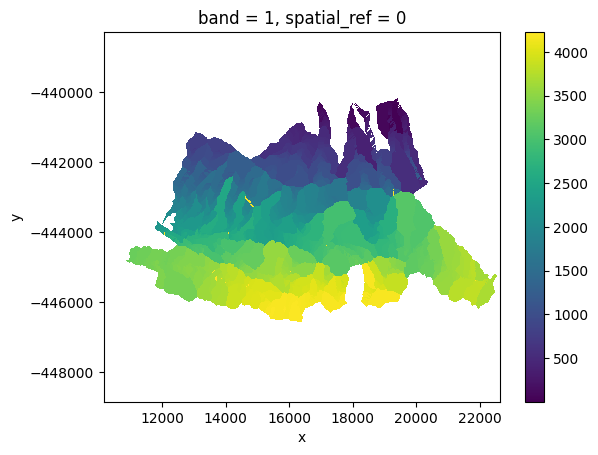

In [17]:
# subbasins
params = {
    'd8_pntr': d8_pntr_file,
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, "basins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
basins = wb_wrapper(wbt.subbasins, params, return_file=False)
basins.where(basins != -32768).plot()

./whitebox_tools --run="Hillslopes" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/basins.tif' -v --compress_rasters=False

****************************
* Welcome to Hillslopes    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.78s


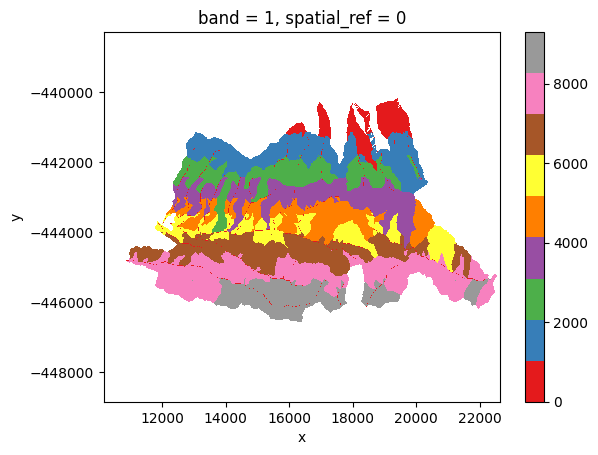

In [18]:
# hillslopes
params = {
    'd8_pntr': d8_pntr_file,
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, "basins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
hillslopes = wb_wrapper(wbt.hillslopes, params, return_file=False)
hillslopes.where(hillslopes != -32768).plot(cmap='Set1')

In [19]:
# snap pour points
# save pour points to shapefile
pour_points.to_file(os.path.join(working_directory, 'pp.shp'))

params = {
    'pour_pts': os.path.join(working_directory, 'pp.shp'), 
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, 'snapped_pp.shp'), 
    'snap_dist': 1000, # in meters
    'callback': my_callback
}

pour_points_file = wb_wrapper(wbt.jenson_snap_pour_points, params, return_file=True)
# read in the shape file
pour_points_snapped = gpd.GeoDataFrame.from_file(pour_points_file)
pour_points_snapped.head(5)

./whitebox_tools --run="JensonSnapPourPoints" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --pour_pts='/Users/arthurkoehl/programs/pasternack/valleys/pp.shp' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/snapped_pp.shp' --snap_dist='1000' -v --compress_rasters=False

***********************************
* Welcome to JensonSnapPourPoints *
* Powered by WhiteboxTools        *
* www.whiteboxgeo.com             *
***********************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.1s


,FID,geometry
0,0,POINT (16534.457 -441107.482)
1,1,POINT (13096.480 -444145.695)
2,2,POINT (12246.980 -443765.918)
3,3,POINT (22291.070 -445195.077)
4,4,POINT (10867.792 -444815.301)


./whitebox_tools --run="Watershed" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --pour_pts='/Users/arthurkoehl/programs/pasternack/valleys/snapped_pp.shp' --output='/Users/arthurkoehl/programs/pasternack/valleys/watersheds.tif' -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.42s


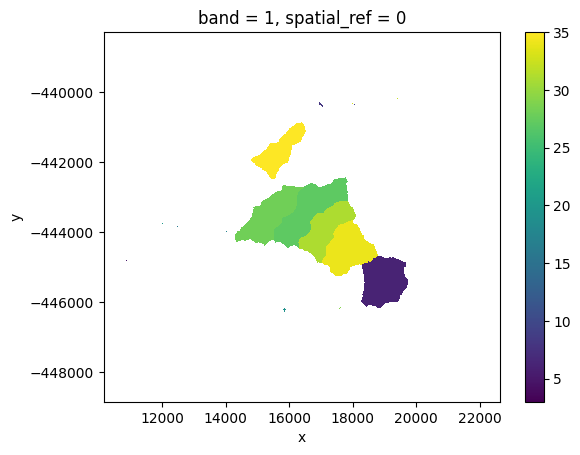

In [20]:
# watershed
params = {
    'd8_pntr': d8_pntr_file, 
    'pour_pts': pour_points_file, 
    'output': os.path.join(working_directory, 'watersheds.tif'), 
    'esri_pntr': False, 
    'callback': my_callback
}
watersheds = wb_wrapper(wbt.watershed, params, return_file=False)
watersheds.where(watersheds != -32768).plot()

In [130]:
# ElevationAboveStream

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

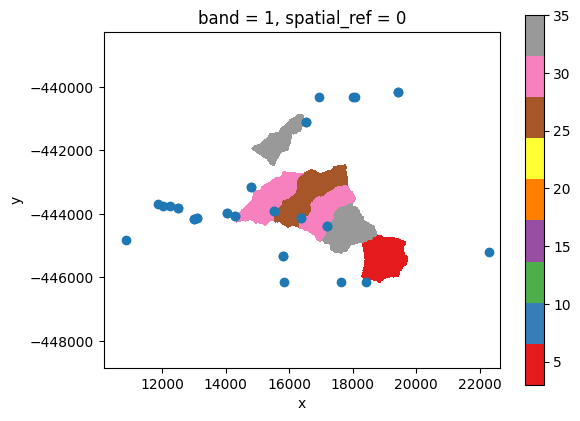

In [112]:
fig, ax = plt.subplots()
watersheds.where(watersheds != -32768).plot(ax=ax, cmap='Set1')
pour_points.plot(ax=ax)